In [1]:
%matplotlib inline
from deco.imports import *
from deco.context import *
import json
from pprint import pprint
import sklearn.ensemble as st
from sklearn.model_selection import *
from datetime import datetime
import random
from math import sin, cos, sqrt, atan2, radians
import networkx as nx
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
PATH = '/home/rotem/Documents/code/optimization-course/'

In [3]:
def choose_columns(df_grid, select_cols=['pickup_datetime', 'trip_time_in_secs', 'trip_distance']):
    df_grid = df_grid.copy()
    df_reference = pd.read_csv(PATH + 'trip_data_1.csv', error_bad_lines=False, warn_bad_lines=False, nrows=1)
    df_grid.columns = list(df_reference.columns) + ['pickup_grid', 'dropoff_grid']
    df_grid = df_grid[select_cols].sort_values(select_cols[0])
    return df_grid

def format_dates(df):
    df = df.copy()
    df.pickup_datetime = pd.to_datetime(df.pickup_datetime, format='%Y-%m-%d %H:%M:%S')
    df['time_of_day'] = df.pickup_datetime.apply(lambda d: d.timestamp() % (24 * 60 * 60))
    df['DATE'] = df.pickup_datetime.dt.strftime('%Y-%m-%d')
    return df

def load_data(pickup_grid='87G8Q279+', dropoff_grid='87G8Q225+'):
    df_grid = pd.read_csv(f'{PATH}/trip_data_{pickup_grid}_{dropoff_grid}.csv', header=None)
    df_grid = choose_columns(df_grid)
    df_grid = format_dates(df_grid)
    return df_grid

In [415]:
def add_holidays(df):
    df = df.copy()
    usa_holidays = pd.read_csv(PATH + 'usholidays.csv')
    usa_holidays.columns = [c.upper() for c in usa_holidays.columns]
    usa_holidays = usa_holidays[['DATE', 'HOLIDAY']]
    df = df.merge(usa_holidays, on=['DATE'], how='left')
    df.HOLIDAY = df.HOLIDAY.apply(lambda v: 1 if v else 0)
    return df

def add_weather(df):
    df = df.copy()
    weather = pd.read_csv(PATH + 'nyc-weather.csv')
    weather = weather[weather.NAME == 'NY CITY CENTRAL PARK, NY US'][['DATE', 'TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5', 'WSF2', 'WSF5']]
    weather.TMAX = (weather.TMAX - 32) * 5.0/9.0
    weather.TMIN = (weather.TMIN - 32) * 5.0/9.0
    df = df.merge(weather, on=['DATE'], )
    return df

def add_date_parts(df):
    df = df.copy()
    attrs = ['Dayofweek', 'Day', 'Month', ]
    for attr in attrs:
        df[f'pickup_datetime{attr.lower()}'] = getattr(df.pickup_datetime.dt, attr.lower())
    return df

def add_stock_daily_diff(df):
    df = df.copy()
    p = pd.read_csv(PATH + 'prices.csv')
    p = p[(p.date >= '2013') & (p.date < '2014') ]
    p.date = p.date.apply(lambda v: v[:10])
    p['price'] = p.close - p.open
    p['DATE'] = p.date
    p = p.groupby('DATE', as_index=False).agg({'close': 'mean', 'open': 'mean'}).sort_values('DATE')
    p = p.reset_index(drop=True).merge(p, left_index=True, right_index=True)
    p['price'] = p.close_x - p.open_y
    p['DATE'] = p.DATE_x
    p = p[['DATE', 'price']]
    display(plt.plot(p.DATE, p.price))
    df = df.merge(p, on=['DATE'], how='left')
    return df

In [417]:
features = [add_holidays, add_weather, add_date_parts]
def apply_features(base_df, features=features):
    df = base_df.copy()
    for feature in features:
        df = feature(df)
    df = df.sort_values('pickup_datetime')
    return df

In [365]:
def clean_anomalys(df):
    df.copy()
    df = df[(df.trip_distance > 0.05) & (df.trip_distance <= 2)]
    return df

In [418]:
df = load_data()
df = apply_features(df)
df = clean_anomalys(df)

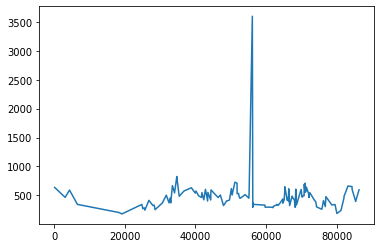

In [174]:
g = df[df.DATE == '2013-03-01'].reset_index(drop=True)
plt.plot(g.time_of_day, g.trip_time_in_secs / g.trip_distance)

In [324]:
## not in use - expiramental removal of "false" drives
# for iteration in range(10):
#     data = df.trip_distance
#     mu, std = norm.fit(data)
#     vals = plt.hist(df.trip_distance, bins=100, density=True, alpha=0.6, color='g')
#     xmin, xmax = plt.xlim()
#     x = np.linspace(xmin, xmax, 50)
#     p = norm.pdf(x, mu, std)
#     plt.plot(x, p, 'k', linewidth=2)
#     title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
#     plt.title(title)
    
#     max_diff = 0
#     max_loc = 0
#     candidate = []
#     for index, bucket in enumerate(list(zip(vals[1], vals[0]))):
#         for point in [item for item in data.drop_duplicates() if vals[1][index] <= item <= vals[1][index + 1]]:
#             d = abs(norm.pdf(point, mu, std) - bucket[1])
#             if d > max_diff:
#                 max_diff = d
#                 max_loc = index
#                 candidate = point
    
# #     max_bucket = list(vals[0]).index(max(vals[0]))
# #     cendidates = [item for item in data.drop_duplicates() if vals[1][max_bucket] <= item <= vals[1][max_bucket + 1]]
# #     max_diff = max(candidates)
#     print(candidate, max_diff, max_loc)
#     df = df[df.trip_distance != candidate]

In [419]:
df = df.drop(['pickup_datetime', 'DATE'], axis=1)

In [421]:
df.WSF5 = df.WSF5.apply(lambda x: 0 if np.isnan(x) else x)
df.WDF5 = df.WDF5.apply(lambda x: 0 if np.isnan(x) else x)
# df.price = df.price.apply(lambda x: 0 if np.isnan(x) else x)
display(df.columns)

Index(['trip_time_in_secs', 'trip_distance', 'time_of_day', 'HOLIDAY', 'TMAX',
       'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5', 'WSF2', 'WSF5',
       'pickup_datetimedayofweek', 'pickup_datetimeday',
       'pickup_datetimemonth'],
      dtype='object')

In [422]:
train_df, test_df = train_test_split(df[df.trip_distance > 0.25], test_size=0.2, random_state=42)
x_train, y_train = train_df.drop('trip_time_in_secs', axis=1), train_df.trip_time_in_secs
x_test, y_test = test_df.drop('trip_time_in_secs', axis=1), test_df.trip_time_in_secs

In [423]:
def l1_diff(x, y):
    return abs((x-y))

In [424]:
tests_results = []

In [427]:
def print_score(m):
    rows = []
    rows.append(['l1 - mean', l1_diff(m.predict(x_train), y_train).mean(), l1_diff(m.predict(x_test), y_test).mean()])
    rows.append(['l1 - std', l1_diff(m.predict(x_train), y_train).std(), l1_diff(m.predict(x_test), y_test).std()])
    rows.append(['l1 - quantile', l1_diff(m.predict(x_train), y_train).quantile(), l1_diff(m.predict(x_test), y_test).quantile()])
    rows.append(['l1 - min', l1_diff(m.predict(x_train), y_train).min(), l1_diff(m.predict(x_test), y_test).min()])
    rows.append(['l1 - max', l1_diff(m.predict(x_train), y_train).max(), l1_diff(m.predict(x_test), y_test).max()])
    rows.append(['r2', m.score(x_train, y_train), m.score(x_test, y_test)])
    df = pd.DataFrame(rows, columns=['name', 'train', 'test'])
    
    if tests_results:
        print('last test:')
        display(tests_results.pop())
    tests_results.append(df)
    print('latest test:')
    display(df)

In [428]:
m = st.RandomForestRegressor(n_jobs=-1, n_estimators=40, max_features=0.9, min_samples_leaf=3, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

last test:


,name,train,test
0,l1 - mean,61.369306,96.271296
1,l1 - std,65.858637,95.533254
2,l1 - quantile,44.426062,72.640691
3,r2,0.877729,0.723321


latest test:


,name,train,test
0,l1 - mean,61.131289,96.219224
1,l1 - std,64.880064,95.639484
2,l1 - quantile,44.524544,72.998403
3,l1 - min,0.005694,0.049713
4,l1 - max,2776.246637,2744.548046
5,r2,0.880100,0.723167


In [32]:
m = st.ExtraTreesRegressor(n_jobs=-1, n_estimators=300, max_features=0.5, min_samples_leaf=3, )
m.fit(x_train, y_train)
print_score(m)

[90.23820928057613, 122.6844316411747, 0.7932020943111237, 0.6149679251313769]


In [19]:
from sklearn.linear_model import LinearRegression
m = LinearRegression()
m.fit(x_train, y_train)
print_score(m)

[191.34498197239742, 187.1700421361616, 0.18748817439192178, 0.17710458812129182]


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
print(f'rows: {len(rows)}')
pm = make_pipeline(PolynomialFeatures(10, order='F'), LinearRegression())
pm.fit(rows, m.predict(rows))
# print_score(pm)

rows: 67


In [87]:
def pretty_preds(preds, buffer=10):
    for i in range(len(preds)):
        preds_range = preds[max(i-buffer, 0):min(i+buffer, len(preds) - 1)]
        preds[i] = sum(preds_range) / len(preds_range)
    return preds

,trip_distance,time_of_day,HOLIDAY,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5,pickup_datetimedayofweek,pickup_datetimeday,pickup_datetimemonth
10368,1.04,75360.0,1,15.0,6.666667,0.0,0.0,0.0,5.82,60.0,180.0,14.1,18.1,0,15,4


M


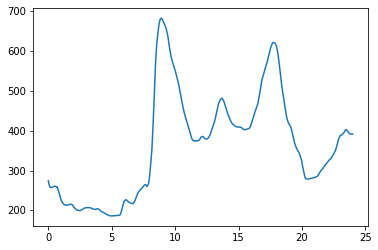

In [455]:
gen = x_test.sample(n=1, random_state=45)
display(gen)
gen = gen.values[0]
cols = list(x_test.columns)
rows = []
for i in range(0, 60 * 60 * 24, 10):
# for i in range(20000, 40000, 1):
    row = gen.copy()
    row[cols.index('time_of_day')] = i
    rows.append(row)
rows = pd.DataFrame(rows, columns=cols)
preds = m.predict(rows)
# plt.plot(rows.time_of_day, preds)
print ('MTWtFSs'[int(gen[-3])])
plt.plot(rows.time_of_day / 60 / 60, pretty_preds(preds, 100))
